### Dataset Generation

This notebook takes you through all the steps in the Dataset generation process. 

We first start with pen-tip trajectories from the UCI Machine Learning repository's character trajectory dataset and subsequently transform it into spindle firing rates.

In [1]:
%matplotlib inline
import os
import h5py

import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns

import sys

sys.path.append('../PCR-data-generation/')

from pcr_data_utils import *
from generate_data_ver_seed import *

In [2]:
params = {
   'axes.labelsize': 20,
   'legend.fontsize': 15,
   'xtick.labelsize': 20,
   'ytick.labelsize': 20,
   'text.usetex': False,
   'figure.figsize': [7,7],
   'font.size': 20,
    'lines.markersize':10,
   }

plt.rcParams.update(params)

In [4]:
# Load processed datasets

PATH_TO_STARTPOINTS = './../PCR-data-generation/start_points'
PATH_TO_TRAJECTORIES = './../PCR-data-generation/'

with h5py.File(os.path.join(PATH_TO_STARTPOINTS, 'pcr_startingpoints_snap_scaled_5.hdf5'), 'r') as myfile:
    startpts_horizontal = myfile['vertical'][()]
    startpts_vertical = myfile['horizontal'][()]

with h5py.File(os.path.join(PATH_TO_TRAJECTORIES, 'pcr_trajectories_5.hdf5'), 'r') as myfile:
    data = myfile['trajectories'][()]
    labels = myfile['labels'][()]

In [5]:
PATH_TO_FIG = '../figures/pcr_generation/'

save_flag = False

if save_flag:
    if not os.path.exists(PATH_TO_FIG):
        os.makedirs(PATH_TO_FIG)

**Original Pen-tip trajectories, upscaled to fit in a 10x10 grid.**

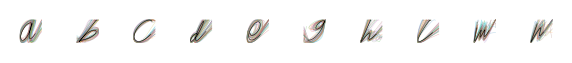

In [5]:
# Plot original trajectories, upscaled to fit in a 10x10cm grid
plt.figure(figsize=[10, 2])
for i in range(1,11):
    classdata = data[labels==i]
    plt.subplot(2, 10, i)
    for j in range(30):
        plt.plot(classdata[j][0, :], classdata[j][1, :], alpha=0.3, linewidth=0.5)
    plt.plot(np.mean(classdata, axis=0)[0, :], np.mean(classdata, axis=0)[1, :], 'k', linewidth=0.5)
    plt.xlim([-5.5, 5.5]); plt.ylim([-5.5, 5.5])
    plt.xticks([]); plt.yticks([]); 
    sns.despine(left=True, bottom=True)

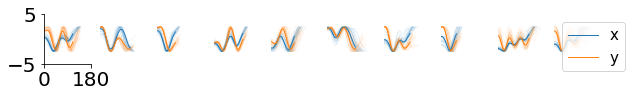

In [6]:
# Same as above, but as trajectories of x and y
plt.figure(figsize=[10, 2])
for i in range(1,11):
    classdata = data[labels==i]
    plt.subplot(2, 10, i)
    for j in range(30):
        plt.plot(classdata[j].T, alpha=0.1, linewidth=0.5)
        plt.gca().set_prop_cycle(None)
    plt.plot(np.mean(classdata, axis=0)[0].T, linewidth=1, label='x')
    plt.plot(np.mean(classdata, axis=0)[1].T, linewidth=1, label='y')
    plt.xlim([0, 180]); plt.xticks([0, 180]); plt.yticks([-5, 5])
    if i != 1:
        plt.gca().axis('off')
    else:
        sns.despine(trim=True)
    if i == 10:
        plt.legend()

**From pen-tip trajectory to end-effector trajectory: varying speed, rotation and scale.**

In [7]:
# Select a random trajectory in order to go through the steps of dataset generation
mytraj = data[90][:, np.all(~np.isnan(data[90]), axis=0)]

# Scale, rotate and vary the speed of the trajectory
scaled_mytraj = resize(mytraj, 1.3)
rotated_mytraj = apply_rotations(scaled_mytraj, 0, 0, 0)
slower_traj = speedify(rotated_mytraj, 0.8)

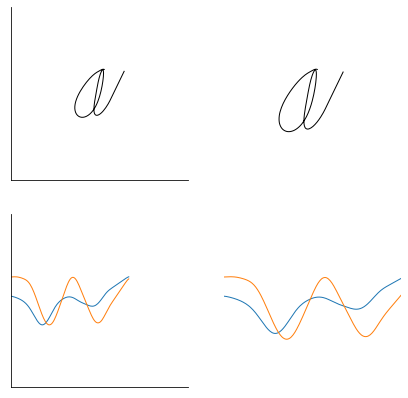

In [8]:
# Plot original and modified trajectories
plt.subplot(2, 2, 1)
plt.plot(mytraj[0], mytraj[1], 'k', linewidth=1)
plt.xlim([-9, 9]); plt.ylim([-9, 9]);
plt.xticks([]); plt.yticks([]);
sns.despine(ax=plt.gca())

plt.subplot(2, 2, 2)
plt.plot(slower_traj[0], slower_traj[1], 'k', linewidth=1)
plt.xlim([-9, 9]); plt.ylim([-9, 9]);
plt.xticks([]); plt.yticks([]);
plt.gca().axis('off')

plt.subplot(2, 2, 3)
plt.plot(mytraj.T, linewidth=1)
plt.xlim([0, 200]); plt.ylim([-9, 9]);
plt.xticks([]); plt.yticks([]);
sns.despine(ax=plt.gca())

plt.subplot(2, 2, 4)
plt.plot(slower_traj.T, linewidth=1)
plt.xlim([0, 200]); plt.ylim([-9, 9]);
plt.xticks([]); plt.yticks([]);
plt.gca().axis('off')
title = 'traj_mod.png'
# plt.savefig(title, dpi=600, format='png')
if save_flag:
    plt.savefig(PATH_TO_FIG + 'ex_traj_augm.png', format='png', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'ex_traj_augm.pdf', format='pdf', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'ex_traj_augm.svg', format='svg', dpi=1200, bbox_inches='tight')

**Translate end-effector trajectory in the arm's workspace: Starting Points in Reachable workspace.**

Please see generate_startpoints.py to learn how to generate a grid of reachable workspace.

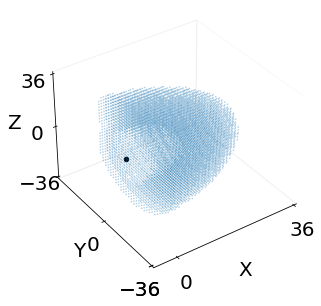

In [9]:
# Plot the reachable workspace
grid_resolution = 2   # in cm
xmax, xmin = 34, -6    # forward and backward
ymax, ymin = 36, -36  # left and right
zmax, zmin = 36, -36  # up and down

X = np.linspace(xmin, xmax, (xmax - xmin)//grid_resolution + 1)
Y = np.linspace(ymin, ymax, (ymax - ymin)//grid_resolution + 1)
Z = np.linspace(zmin, zmax, (zmax - zmin)//grid_resolution + 1)
x, y = np.meshgrid(Y, Z)

ax = plt.figure(figsize=[5, 5]).gca(projection='3d')
ax.scatter(startpts_vertical[:, 0], startpts_vertical[:, 1], startpts_vertical[:, 2], s=0.4, alpha=0.3)
ax.scatter([0], [0], [0], color='black')
# ax.scatter(startpts_vertical[577, 0], startpts_vertical[577, 1], startpts_vertical[577, 2], s=3, color='black') #900
ax.set_xlim([xmin, xmax]); ax.set_ylim([ymin, ymax]); ax.set_zlim([zmin, zmax])
ax.xaxis.pane.fill = False; ax.yaxis.pane.fill = False; ax.zaxis.pane.fill = False
ax.view_init(elev=35, azim=-125)
ax.grid(False)
ax.set_xticks([0, 36]); ax.set_yticks([-36, 0, -36]); ax.set_zticks([-36, 0, 36]) #before
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
title = 'start_points.png'
# plt.savefig(title, dpi=600, format='png')

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.zaxis.set_tick_params(labelsize=20)

if save_flag:
    plt.savefig(PATH_TO_FIG + 'start_points.png', format='png', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'start_points.pdf', format='pdf', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'start_points.svg', format='svg', dpi=1200, bbox_inches='tight')

**Translate end-effector trajectory into the arm's workspace.**

In [10]:
traj_3d = np.insert(slower_traj, 2, 0, axis=0)
plane_to_world = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 0]])
endeffector_coordinates = plane_to_world.dot(traj_3d) 
endeffector_coordinates += startpts_vertical[900][:, None]

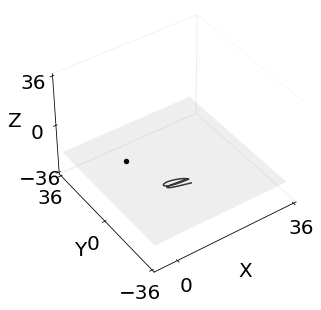

In [11]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=[5, 5])

plane = np.where(np.std(endeffector_coordinates, axis=1) < 1e-5)[0][0]
if plane == 0:
    y, z = np.meshgrid(Y, Z)
    x = np.zeros_like(y) + endeffector_coordinates[plane, 0]
elif plane == 2:
    x, y = np.meshgrid(X, Y)
    z = np.zeros_like(y) + endeffector_coordinates[plane, 0]    
    
ax = fig.gca(projection='3d')
ax.plot_surface(x, y, z, color='gray', alpha=0.1)
ax.plot(endeffector_coordinates[0], endeffector_coordinates[1], endeffector_coordinates[2], color='k', alpha=0.8)
ax.scatter([0], [0], [0], color='black')
ax.set_xlim([xmin, xmax]); ax.set_ylim([ymin, ymax]); ax.set_zlim([zmin, zmax])
ax.xaxis.pane.fill = False; ax.yaxis.pane.fill = False; ax.zaxis.pane.fill = False
ax.view_init(elev=40, azim=-125)
ax.grid(False)
ax.set_xticks([0, 36]); ax.set_yticks([-36, 0, 36]); ax.set_zticks([-36, 0, 36])
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
title = 'traj3d.png'
# plt.savefig(title, dpi=600, format='png')

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.zaxis.set_tick_params(labelsize=20)

if save_flag:
    plt.savefig(PATH_TO_FIG + 'traj_3d.png', format='png', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'traj_3d.pdf', format='pdf', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'traj_3d.svg', format='svg', dpi=1200, bbox_inches='tight')

**Derive Joint angle configurations for the generated endeffector trajectory.**

In [13]:
joint_traj, error = make_joint_config(endeffector_coordinates, monkey_name='snap')

myarm = Arm(monkey_name='snap')
shoulder_to_world = np.array([[0, 0, -1], [-1, 0, 0], [0, 1, 0]])

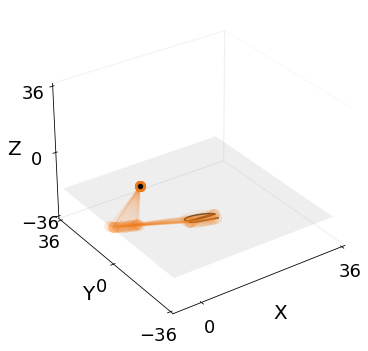

In [14]:
fig = plt.figure(figsize=[6, 6])
ax = fig.gca(projection='3d')
ax.plot_surface(x, y, z, color='gray', alpha=0.1)
ax.plot(endeffector_coordinates[0], endeffector_coordinates[1], endeffector_coordinates[2], color='k', alpha=0.8)

for i in range(endeffector_coordinates.shape[1]//5):
    try: 
        pos = endeffector_coordinates[:, i*5]
        link_pos = shoulder_to_world.dot(myarm.get_xyz(joint_traj[:, i*5])[1])
        ax.plot(link_pos[0, :], link_pos[1, :], link_pos[2, :], marker='o', color='C1', alpha=(i/300))
    except:
        break

ax.scatter([0], [0], [0], color='black')
ax.set_xlim([xmin, xmax]); ax.set_ylim([ymin, ymax]); ax.set_zlim([zmin, zmax])
ax.xaxis.pane.fill = False; ax.yaxis.pane.fill = False; ax.zaxis.pane.fill = False
ax.view_init(elev=30, azim=-125)
ax.grid(False)
ax.set_xticks([0, 36]); ax.set_yticks([-36, 0, 36]); ax.set_zticks([-36, 0, 36])
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
title = 'joint_3d.png'
# plt.savefig(title, dpi=600, format='png')

ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
ax.zaxis.set_tick_params(labelsize=18)

if save_flag:
    plt.savefig(PATH_TO_FIG + 'traj_3d_link.png', format='png', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'traj_3d_link.pdf', format='pdf', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'traj_3d_link.svg', format='svg', dpi=1200, bbox_inches='tight')

<ipython-input-15-4c318e46fbcb>:5: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([0, 200], [0, 2]); plt.yticks([-50, 0, 100])


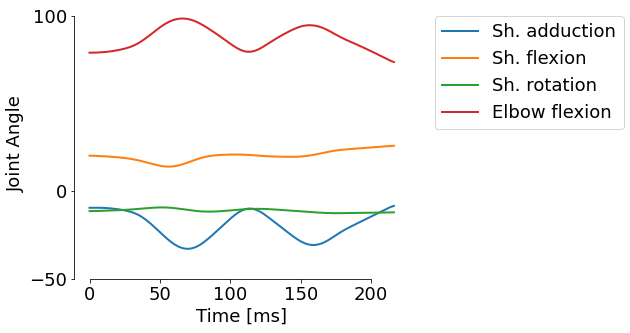

In [15]:
# Plot joint angles as trajectories in time
fig, ax = plt.subplots(figsize=[6,5])
# plt.figure(figsize=[5,4])
ax.plot(joint_traj.T, linewidth=2)
ax.set_xticks([0, 200], [0, 2]); plt.yticks([-50, 0, 100])
ax.set_xlabel('Time [ms]',fontsize = 18)
ax.set_ylabel('Joint Angle',fontsize = 18)
# plt.legend(('a', 'b', 'c', 'd'))
ax.legend(('Sh. adduction', 'Sh. flexion', 'Sh. rotation', 'Elbow flexion'),bbox_to_anchor=(1.05, 1), loc=2,fontsize=18)
sns.despine(trim=True)

ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)

if save_flag:
    plt.savefig(PATH_TO_FIG + 'joint_angle.png', format='png', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'joint_angle.pdf', format='pdf', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'joint_angle.svg', format='svg', dpi=1200, bbox_inches='tight')

**Generate muscle configurations from joint configurations.**

In [16]:
import opensim as osim
mymodel = osim.Model('./../PCR-data-generation/all_monkey_arm/Snap/Snap_scaled_fin1.osim')
muscle_config, marker3, marker6 = make_muscle_config(mymodel, joint_traj)

<ipython-input-17-783c77678067>:4: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([0, 200], [0, 4]);


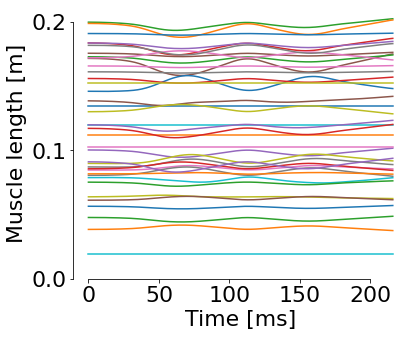

In [17]:
# plt.figure(figsize=[6,5])
fig, ax = plt.subplots(figsize=[6,5])
ax.plot(muscle_config.T/1000, linewidth=1.5)
ax.set_xticks([0, 200], [0, 4]); 
ax.set_yticks([0, 0.100, 0.200])
ax.set_xlabel('Time [ms]',fontsize=22); plt.ylabel('Muscle length [m]',fontsize=22)
sns.despine(trim=True)

ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

if save_flag:
    plt.savefig(PATH_TO_FIG + 'muscle_len.png', format='png', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'muscle_len.pdf', format='pdf', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'muscle_len.svg', format='svg', dpi=1200, bbox_inches='tight')

In [18]:
time_step = 0.01
vel_tmp = np.float32(np.gradient(muscle_config/1000,time_step,axis=1))

<ipython-input-19-70745072db24>:4: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([0, 200], [0, 4]);


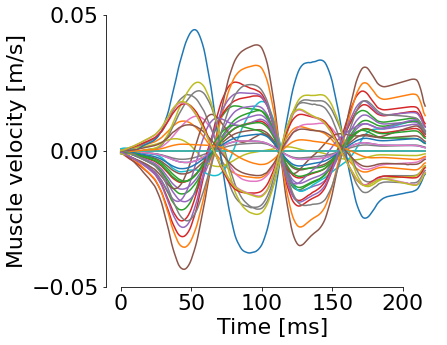

In [19]:
# plt.figure(figsize=[6,5])
fig, ax = plt.subplots(figsize=[6,5])
ax.plot(vel_tmp.T, linewidth=1.5)
ax.set_xticks([0, 200], [0, 4]); 
ax.set_yticks([-0.050, 0, 0.050])
ax.set_xlabel('Time [ms]',fontsize=22); plt.ylabel('Muscle velocity [m/s]',fontsize=22)
sns.despine(trim=True)

ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

if save_flag:
    plt.savefig(PATH_TO_FIG + 'muscle_vel.png', format='png', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'muscle_vel.pdf', format='pdf', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'muscle_vel.svg', format='svg', dpi=1200, bbox_inches='tight')